# 1. Importing Dependencies


## 1.1 Importing Dependency Packages

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import BatchNormalization, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD, Adam

In [62]:
storage = {
    "model": None,
    "scaler": None,
    "means": None
}

## 1.2. Mounting Google Drive

## 1.3 Loading the Main Data

In [63]:
columns = ['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall']

In [64]:
# Detect outliers in numerical columns
numeric_columns = ['AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA', 'AgeAtCalvingInDays',
       'AgeAtCalvingInMonths', 'MostRecentBodyScore', 'MostRecentMotionScore',
       'AverageBodyScore', 'AverageMotionScore', 'InbreedingCoefficient',
       'PregnancyLengthMonths', 'Milk',
       'MilkDays', 'MilkFat', 'MilkProtein',
       'DIMAtBreeding', 'Lactation',
       'LengthInDays', 'DaysOpen', 'TimesBred', 'AverageMilk', 'ECM',
       'FatProteinRatio']

good_features = ['Serial', 'AgeAtCalvingInDays', 'AverageBodyScore',
       'AverageMotionScore', 'InbreedingCoefficient', 'StillBirth', 'Abortion',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'DaysOpen', 'TimesBred',
       'Lameness', 'Mastitis', 'Ketosis', 'RetainedPlacenta',
       'DisplacedAbomasum', 'Winter', 'Spring', 'Summer', 'Fall',
       'AverageMilk', 'ECM', 'FatProteinRatio']

In [65]:
# Use the Pandas library to read the CSV file
data = pd.read_csv('days-open-v9.csv', dtype= {'Serial': str}, names= columns)

In [67]:
data['Serial'].nunique()

5557

In [68]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall'],
      dtype='object')

In [70]:
logical_data = data.copy()

In [71]:
logical_data = logical_data[(logical_data['AgeAtCalvingInMonthsA'] > 20)]
logical_data.shape

(16280, 33)

In [72]:
logical_data = logical_data[(logical_data['AgeAtCalvingInMonths'] > 20)]
logical_data.shape

(16280, 33)

In [73]:
logical_data = logical_data[(logical_data['AverageBodyScore'] >= 1) & (logical_data['AverageBodyScore'] <= 9)]
logical_data.shape

(11562, 33)

In [74]:
# logical_data = logical_data[(logical_data['DaysOpen'] >= 70) & (logical_data['DaysOpen'] <= 365)]
logical_data.shape

(11562, 33)

In [75]:
data = logical_data

# 2. Data Processing
In this part we use process the data, merge it disorders data and then clean the data, remove the outliers and normalize it to be ready for the model

In [77]:
data['AverageMilk'] = data['Milk'] / data['MilkDays']

In [78]:
mask = np.isnan(data["MilkFat"]) | np.isnan(data["MilkProtein"]) | np.isnan(data["Milk"])

data["ECM"] = np.nan
data.loc[~mask, "ECM"] = 0.327 * data["Milk"] + 12.95 * data["MilkFat"] + 7.65 * data["MilkProtein"]



In [79]:

data["FatProteinRatio"] = np.nan
data.loc[~mask, "FatProteinRatio"] = data["MilkFat"] / data["MilkProtein"]


In [80]:
data

,Serial,AgeAtCalvingInDaysA,AgeAtCalvingInMonthsA,AgeAtCalvingInDays,AgeAtCalvingInMonths,MostRecentBodyScore,MostRecentMotionScore,AverageBodyScore,AverageMotionScore,InbreedingCoefficient,...,Ketosis,RetainedPlacenta,DisplacedAbomasum,Winter,Spring,Summer,Fall,AverageMilk,ECM,FatProteinRatio
4757,3251389070105150,1418,47,1606,53,1.75,3.0,1.833333,3.0,0.000000,...,0,0,0,1,0,0,0,33.905290,3248.49975,NaN
4758,3251387112506750,1513,50,2105,69,2.50,NaN,2.031250,NaN,4.687500,...,0,0,0,0,0,0,1,NaN,NaN,NaN
4759,3251387112506750,1824,60,2105,69,2.50,NaN,2.031250,NaN,4.687500,...,0,0,0,0,0,0,1,NaN,NaN,NaN
4760,3251390032502390,1037,34,1435,47,1.75,NaN,2.050000,NaN,NaN,...,0,0,0,0,1,0,0,31.724023,2759.41893,NaN
4761,3251385090704880,2832,93,3126,103,2.25,3.0,2.055556,4.0,1.129151,...,0,0,0,0,1,1,0,28.922913,3376.43196,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16467,3251388033002190,1991,66,2277,75,3.50,NaN,4.305556,NaN,0.720215,...,0,1,0,0,0,1,1,NaN,NaN,NaN
16468,3251386091305310,3630,119,4025,132,4.25,2.0,4.409091,2.0,0.073242,...,0,0,0,1,0,0,1,44.493436,4233.86193,NaN
16469,3251387012800560,1934,64,2283,75,4.50,NaN,4.416667,NaN,0.000000,...,0,1,0,0,0,1,0,NaN,NaN,NaN
16470,3251382030300980,2174,72,2601,86,4.50,NaN,4.500000,NaN,0.195313,...,0,0,0,0,0,1,0,28.428000,2231.02944,NaN


In [81]:
data.columns

Index(['Serial', 'AgeAtCalvingInDaysA', 'AgeAtCalvingInMonthsA',
       'AgeAtCalvingInDays', 'AgeAtCalvingInMonths', 'MostRecentBodyScore',
       'MostRecentMotionScore', 'AverageBodyScore', 'AverageMotionScore',
       'InbreedingCoefficient', 'PregnancyLengthMonths', 'Milk', 'MilkDays',
       'MilkFat', 'MilkProtein', 'StillBirth', 'Abortion', 'DIMAtBreeding',
       'Lactation', 'MultiBirth', 'NaturalBreeding', 'LengthInDays',
       'DaysOpen', 'TimesBred', 'Lameness', 'Mastitis', 'Ketosis',
       'RetainedPlacenta', 'DisplacedAbomasum', 'Winter', 'Spring', 'Summer',
       'Fall', 'AverageMilk', 'ECM', 'FatProteinRatio'],
      dtype='object')

In [82]:


outliers = data[numeric_columns].apply(lambda x: (x - x.mean()).abs() > 3 * x.std())
outlier_counts = outliers.sum()

outlier_counts


AgeAtCalvingInDaysA      167
AgeAtCalvingInMonthsA    169
AgeAtCalvingInDays       163
AgeAtCalvingInMonths     159
MostRecentBodyScore       57
MostRecentMotionScore      0
AverageBodyScore          75
AverageMotionScore        48
InbreedingCoefficient     84
PregnancyLengthMonths    255
Milk                      29
MilkDays                  71
MilkFat                   20
MilkProtein               15
DIMAtBreeding            281
Lactation                233
LengthInDays             203
DaysOpen                 281
TimesBred                250
AverageMilk               11
ECM                       33
FatProteinRatio           17
dtype: int64

In [83]:
standard_data = data.copy()  # Create a copy of the original DataFrame
# Handling outliers
for column in numeric_columns:
    mean = standard_data[column].mean()
    std = standard_data[column].std()
    upper_bound = mean + 3 * std
    lower_bound = mean - 3 * std

    standard_data.loc[:, column] = standard_data.loc[:, column].clip(lower=lower_bound, upper=upper_bound)



In [84]:
# Check the number of missing values in each column
missing_values_count = standard_data.isnull().sum()
print(missing_values_count)


Serial                      0
AgeAtCalvingInDaysA         0
AgeAtCalvingInMonthsA       0
AgeAtCalvingInDays          0
AgeAtCalvingInMonths        0
MostRecentBodyScore         0
MostRecentMotionScore    6195
AverageBodyScore            0
AverageMotionScore       6195
InbreedingCoefficient    7579
PregnancyLengthMonths       0
Milk                     7811
MilkDays                 7811
MilkFat                  7811
MilkProtein              7811
StillBirth                  0
Abortion                    0
DIMAtBreeding               0
Lactation                   0
MultiBirth                  0
NaturalBreeding             0
LengthInDays                0
DaysOpen                    0
TimesBred                   0
Lameness                    0
Mastitis                    0
Ketosis                     0
RetainedPlacenta            0
DisplacedAbomasum           0
Winter                      0
Spring                      0
Summer                      0
Fall                        0
AverageMil

In [85]:
import pandas as pd

filled_data = standard_data.copy()  # Create a copy of the original DataFrame


mean_values = {}  # Dictionary to store the mean values

# fill NaN values with mean value of each column
for col in numeric_columns:
    mean_val = filled_data[col].mean()
    mean_values[col] = mean_val  # Save the mean value for each column
    filled_data[col].fillna(mean_val, inplace=True)

storage["means"] = mean_values

In [86]:
# # To have good features
filled_data = filled_data[good_features]


In [43]:
#filled_data = filled_data[(filled_data['DaysOpen'] > 70) & (filled_data['DaysOpen'] <= 200)]


In [87]:
filled_data = filled_data[filled_data['DaysOpen'] > 0 ]

In [90]:
filled_data['DaysOpen'].describe()

count    11559.000000
mean       136.710887
std         98.566710
min          1.000000
25%         67.000000
50%        106.000000
75%        168.000000
max        464.192669
Name: DaysOpen, dtype: float64

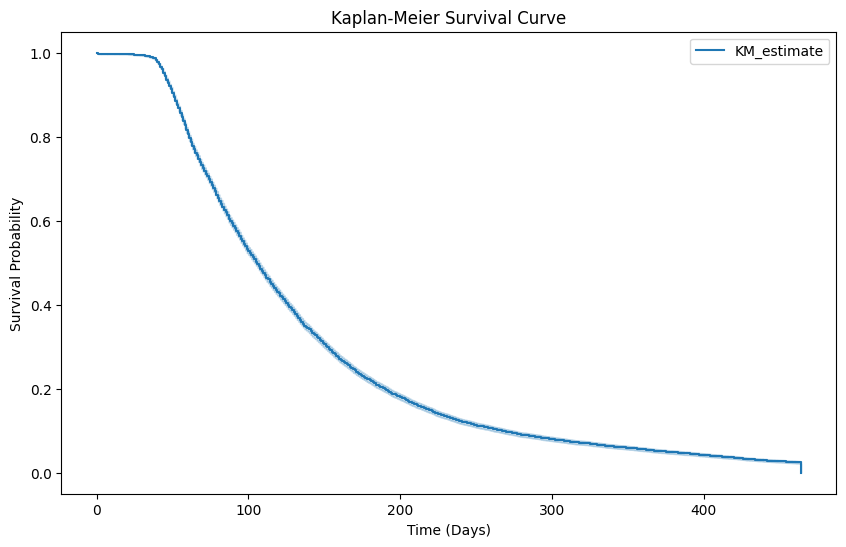

In [91]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from lifelines import KaplanMeierFitter
from lifelines import CoxPHFitter

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1
# Initialize Kaplan-Meier estimator
kmf = KaplanMeierFitter()

# Fit the Kaplan-Meier estimator to your data
kmf.fit(durations=cox_data['DaysOpen'], event_observed=cox_data['Event'])

# Plot the Kaplan-Meier survival curve
plt.figure(figsize=(10, 6))
kmf.plot()
plt.title('Kaplan-Meier Survival Curve')
plt.xlabel('Time (Days)')
plt.ylabel('Survival Probability')
plt.show()


In [92]:
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio

# Set the dark theme
pio.templates.default = "plotly_dark"

In [48]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['DaysOpen'], name='Days Open', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='Days Open Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='Days Open', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [49]:
# # Box Plots (Horizontal)
# fig = go.Figure()
# fig.add_trace(go.Box(x=filled_data['AgeAtCalvingInDays'], name='AgeAtCalvingInDays', orientation='h'))  # Set orientation to 'h' for horizontal
# fig.update_layout(
#     title='AgeAtCalvingInDays Box Plot',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(title='AgeAtCalvingInDays', color='white'),  # Set x-axis title and font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
# )
# fig.show()


In [50]:
# # Seasons Pie Chart
# season_counts = filled_data[['Winter', 'Spring', 'Summer', 'Fall']].sum()
# fig = go.Figure(data=[go.Pie(labels=season_counts.index, values=season_counts.values)])
# fig.update_layout(
#     title='Seasons Pie Chart',
#     font=dict(color='white'),  # Set font color
# )
# fig.show()

In [51]:
# import plotly.figure_factory as ff
# import numpy as np

# # Select numeric columns for correlation matrix
# numeric_columns = filled_data.select_dtypes(include=[np.number])

# # Compute correlation matrix
# corr_matrix = numeric_columns.corr()

# # Format correlation values with desired precision
# corr_values = corr_matrix.apply(lambda x: np.round(x, 2)).values.tolist()

# # Convert correlation matrix columns to a list
# corr_columns = corr_matrix.columns.tolist()

# # Create the correlation heatmap
# fig = ff.create_annotated_heatmap(
#     z=corr_values,
#     x=corr_columns,
#     y=corr_columns,
#     colorscale='Viridis',
#     colorbar=dict(title='Correlation'),
# )

# # Update layout
# fig.update_layout(
#     title='Correlation Heatmap',
#     font=dict(color='white'),  # Set font color
#     xaxis=dict(tickfont=dict(color='white')),  # Set x-axis tick font color
#     yaxis=dict(tickfont=dict(color='white')),  # Set y-axis tick font color
#     height=1500,  # Set the height of the figure
#     width=1500,  # Set the width of the figure
# )

# fig.show()


In [93]:
len(filled_data['Serial'].unique())

4548

In [94]:
columns = filled_data.columns.to_list()
columns_to_remove = ['Serial', 'Lactation']  # Columns to remove from the sequence
feature_columns = [col for col in columns if col not in columns_to_remove]

In [95]:
feature_columns

['AgeAtCalvingInDays',
 'AverageBodyScore',
 'AverageMotionScore',
 'InbreedingCoefficient',
 'StillBirth',
 'Abortion',
 'MultiBirth',
 'NaturalBreeding',
 'DaysOpen',
 'TimesBred',
 'Lameness',
 'Mastitis',
 'Ketosis',
 'RetainedPlacenta',
 'DisplacedAbomasum',
 'Winter',
 'Spring',
 'Summer',
 'Fall',
 'AverageMilk',
 'ECM',
 'FatProteinRatio']

In [201]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import StandardScaler, MinMaxScaler


def generate_sequences(data, feature_cols, target_column, cow_serials):
    sequences = []
    targets = []
    seq_lengths = []

    for cow_serial in cow_serials:
        cow_data = data[data['Serial'] == cow_serial].values
        cow_data = cow_data[np.argsort(cow_data[:, columns.index('Lactation')])]

        for start_index in range(len(cow_data)):
            for end_index in range(start_index + 1, len(cow_data) + 1):
                seq_data = cow_data[start_index:end_index]
                targets.append(seq_data[-1, columns.index(target_column)])

                seq_data = np.delete(seq_data, [columns.index(col) for col in columns_to_remove], axis=1)

                sequences.append(seq_data)
                seq_lengths.append(len(seq_data))

    return sequences, targets, seq_lengths

def split_data(data, validation_ratio=0.1, test_ratio=0.2, seed=0):
    np.random.seed(seed)
    unique_serials = data['Serial'].unique()
    np.random.shuffle(unique_serials)

    num_samples = len(unique_serials)
    num_validation = int(num_samples * validation_ratio)
    num_test = int(num_samples * test_ratio)

    validation_serials = unique_serials[:num_validation]
    test_serials = unique_serials[num_validation:num_validation + num_test]
    train_serials = unique_serials[num_validation + num_test:]

    train_sequences, train_targets, seq_len_train = generate_sequences(data, feature_columns, 'DaysOpen', train_serials)
    val_sequences, val_targets, seq_len_val = generate_sequences(data, feature_columns, 'DaysOpen', validation_serials)
    test_sequences, test_targets, seq_len_test = generate_sequences(data, feature_columns, 'DaysOpen', test_serials)

    return train_sequences, train_targets, seq_len_train, val_sequences, val_targets, seq_len_val, test_sequences, test_targets, seq_len_test

def pad_and_stack_sequences(sequences, targets, max_sequence_length=15):
    padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', dtype='float32')
    X = np.stack(padded_sequences)
    y = np.array(targets)

    return X, y

def create_data(data, seed=0):
    train_sequences, train_targets, seq_len_train, val_sequences, val_targets, seq_len_val, test_sequences, test_targets, seq_len_test = split_data(data, seed=seed)

    X_train, y_train = pad_and_stack_sequences(train_sequences, train_targets, max_sequence_length=10)
    X_val, y_val = pad_and_stack_sequences(val_sequences, val_targets, max_sequence_length=10)
    X_test, y_test = pad_and_stack_sequences(test_sequences, test_targets, max_sequence_length=10)

    scaler = StandardScaler()
    scaler.fit(X_train.reshape(-1, X_train.shape[-1]))

    X_train = scaler.transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
    X_val = scaler.transform(X_val.reshape(-1, X_val.shape[-1])).reshape(X_val.shape)
    X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

    storage["scaler"] = scaler

    return X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test



X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test = create_data(filled_data)


In [202]:
filled_data['Serial'].unique().shape

(4548,)

In [203]:
# import matplotlib.pyplot as plt

# def plot_sequence_lengths(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Create the bar chart
#     plt.figure(figsize=(10, 6))
#     plt.bar(range(len(sequence_lengths)), sequence_lengths)
#     plt.xlabel('Sequence Index')
#     plt.ylabel('Sequence Length')
#     plt.title('Lengths of Sequences')
#     plt.show()

# # Plot for train sequences
# plot_sequence_lengths(train_sequences)

# # Plot for validation sequences
# plot_sequence_lengths(val_sequences)

# # Plot for test sequences
# plot_sequence_lengths(test_sequences)


In [204]:
# import plotly.graph_objects as go

# def plot_sequence_length_distribution(sequences):
#     # Calculate the lengths of each sequence
#     sequence_lengths = [seq.shape[0] for seq in sequences]

#     # Calculate the count of sequences for each length
#     sequence_length_counts = {length: sequence_lengths.count(length) for length in range(1, max(sequence_lengths) + 1)}

#     # Create the bar plot
#     fig = go.Figure(data=[go.Bar(x=list(sequence_length_counts.keys()), y=list(sequence_length_counts.values()))])
#     fig.update_layout(title='Distribution of Sequence Lengths',
#                       xaxis_title='Sequence Length',
#                       yaxis_title='Count',
#                       xaxis=dict(dtick=1),
#                       yaxis=dict(type='log', dtick=1))

#     fig.show()

# # Plot for train sequences
# plot_sequence_length_distribution(train_sequences)

# # Plot for validation sequences
# plot_sequence_length_distribution(val_sequences)

# # Plot for test sequences
# plot_sequence_length_distribution(test_sequences)


In [205]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from keras.models import Sequential
from keras.layers import LSTM, Dense, Masking, TimeDistributed, Flatten
from keras import backend as K

# Activate matplotlib interactive mode
plt.ion()


In [206]:
import pandas as pd
from lifelines import CoxPHFitter
from lifelines.utils import concordance_index
from itertools import product

cox_data = filled_data.drop('Serial', axis=1).copy()
cox_data['Event'] = 1


# Assuming 'cox_data' is your DataFrame
# Split your data into a training set and a test set
train_data, test_data = train_test_split(cox_data, test_size=0.2, random_state=42)  # Adjust test_size as needed

best_params = {'alpha': 0.01, 'n_baseline_knots': 2, 'l1_ratio': 0.0}
# After the loop, use the best hyperparameters to train the model
best_alpha = best_params['alpha']
best_n_baseline_knots = best_params['n_baseline_knots']
best_l1_ratio = best_params['l1_ratio']

# Initialize Cox proportional hazards model with the best hyperparameters
coxph_best = CoxPHFitter(alpha=0.01, n_baseline_knots=2)

# Fit the Cox model to the training data with the best hyperparameters
coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

predicted_median_survival_time = coxph_best.predict_expectation(test_data)



In [207]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Bidirectional, SimpleRNN, GRU, Dense

def get_model(model_type='LSTM'):
    if model_type == 'LSTM':
        rnn_layer_1 = LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = LSTM(32)
    elif model_type == 'BiLSTM':
        rnn_layer_1 = Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
        rnn_layer_2 = Bidirectional(LSTM(32))
    elif model_type == 'RNN':
        rnn_layer_1 = SimpleRNN(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))
        rnn_layer_2 = SimpleRNN(32)
    else:
        raise ValueError("Invalid model_type. Choose from 'LSTM', 'BiLSTM', 'RNN', or 'GRU'.")

    model = Sequential()
    model.add(rnn_layer_1)
    model.add(rnn_layer_2)
    model.add(Dense(16, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1))

    model.compile(loss='mean_absolute_error', optimizer='adam', metrics=['mean_absolute_error'])
    return model


In [208]:
from IPython.display import clear_output

def train_model(model_type, train_X, train_y, val_X, val_y, patience=3):
    model = get_model(model_type)

    # Initialize lists for storing MAE values and attention weights
    train_mae = []
    val_mae = []
    train_seq_lengths = [len(seq) for seq in train_X]

    best_val_mae = float('inf')
    epochs_without_improvement = 0

    for epoch in range(1, 10):  # You can adjust the maximum number of epochs here
        history = model.fit(train_X, train_y, epochs=1, batch_size=32, validation_data=(val_X, val_y),
                            sample_weight=np.array(train_seq_lengths), verbose=0)

        # Update lists with MAE values
        train_mae.append(history.history['mean_absolute_error'][0])
        val_mae.append(history.history['val_mean_absolute_error'][0])

        # Check for early stopping
        if val_mae[-1] < best_val_mae:
            best_val_mae = val_mae[-1]
            epochs_without_improvement = 0
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch} epochs.")
                break


    # Deactivate matplotlib interactive mode
    plt.ioff()

    return model


In [209]:
models = {
    "LSTM": None,
    "BiLSTM": None,
    "RNN": None,
}

In [210]:
# from tensorflow.keras.utils import plot_model

# plot_model(models["RNN"], to_file='model_plot.png', show_shapes=True, show_layer_names=True)
# from IPython.display import Image, display

# # Assuming 'model_plot.png' is the file name
# display(Image(filename='model_plot.png'))

In [211]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_model(model, X_test, y_test):
    # Use the model to make predictions
    y_pred = model.predict(X_test)

    # Flatten the predictions to 1D arrays
    y_test_flattened = y_test.flatten()
    y_pred_flattened = y_pred.flatten()

    # Calculate evaluation metrics
    mae_val = mean_absolute_error(y_test_flattened, y_pred_flattened)
    mse_val = mean_squared_error(y_test_flattened, y_pred_flattened)
    r2_val = r2_score(y_test_flattened, y_pred_flattened)
    c_index = concordance_index(y_test_flattened, y_pred_flattened)

    return mae_val, mse_val, r2_val, c_index


In [212]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from lifelines.utils import concordance_index
import matplotlib.pyplot as plt

def evaluate_cox_model(test_data, predicted_median_survival_time):
    # Extract the observed event times and event indicators from the test data
    observed_times = test_data['DaysOpen']
    event_observed = test_data['Event']

    # Filter out infinite values from observed_times and predicted_median_survival_time
    finite_mask = np.isfinite(observed_times) & np.isfinite(predicted_median_survival_time)
    observed_times_finite = observed_times[finite_mask]
    predicted_median_survival_time_finite = predicted_median_survival_time[finite_mask]

    # Calculate the C-index
    c_index = concordance_index(observed_times_finite, predicted_median_survival_time_finite, event_observed[finite_mask])

    # Calculate Mean Absolute Error (MAE) for Survival, ignoring infinite values
    mae_survival = mean_absolute_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate Mean Squared Error (MSE) for Survival, ignoring infinite values
    mse_survival = mean_squared_error(observed_times_finite, predicted_median_survival_time_finite)

    # Calculate R2 score for Survival, ignoring infinite values
    r2_survival = r2_score(observed_times_finite, predicted_median_survival_time_finite)

    return c_index, mae_survival, mse_survival, r2_survival



In [213]:
# Define the number of training runs
num_training_runs = 1

# Create a dictionary to store evaluation results
evaluation_results = {model_type: {metric: [] for metric in ['C-Index', 'MAE', 'MSE', 'R2']} for model_type in ['RNN', 'Cox', 'LSTM', 'BiLSTM']}

# Perform multiple training runs
for run in range(num_training_runs):
    print(f"Training Run {run + 1}")

    # Train RNN models
    for model_type in ['LSTM', 'BiLSTM', 'RNN']:
        print(f"Training {model_type}")
        X_train, y_train, seq_len_train, X_val, y_val, seq_len_val, X_test, y_test, seq_len_test = create_data(filled_data, run)
        models[model_type] = train_model(model_type, X_train, y_train, X_val, y_val)

        # Evaluate the model
        mae_val, mse_val, r2_val, c_index = evaluate_model(models[model_type], X_test, y_test)
        evaluation_results[model_type].get('MAE').append(mae_val)
        evaluation_results[model_type].get('MSE').append(mse_val)
        evaluation_results[model_type].get('R2').append(r2_val)
        evaluation_results[model_type].get('C-Index').append(c_index)

    # Train Cox model
    train_data, test_data = train_test_split(cox_data, test_size=0.2, random_state=run)  # Adjust test_size as needed
    coxph_best = CoxPHFitter(alpha=0.01, n_baseline_knots=2)
    coxph_best.fit(train_data, duration_col='DaysOpen', event_col='Event')

    # Evaluate the Cox model
    cox_evaluation_results = evaluate_cox_model(test_data, coxph_best.predict_expectation(test_data))
    for metric, value in zip(['C-Index', 'MAE', 'MSE', 'R2'], cox_evaluation_results):
        evaluation_results['Cox'][metric].append(value)


Training Run 1
Training LSTM
159/159 [==============================] - 2s 6ms/step
Training BiLSTM
159/159 [==============================] - 3s 6ms/step
Training RNN


In [ ]:
import pandas as pd
metrics = ['C-Index', 'MAE', 'MSE', 'R2']

# Create a list to store the results
results_list = []
model_names = ['RNN', 'Cox', 'LSTM', 'BiLSTM']
# Iterate over training runs
for run in range(num_training_runs):
    # Create a dictionary to store the results of the current run
    run_results = {'Experiment': f'Experiment {run + 1}'}

    # Iterate over models
    for model_type in model_names:
        # Iterate over metrics
        for metric in metrics:
            # Add results to the dictionary
            run_results[f'{model_type} - {metric}'] = evaluation_results[model_type][metric][run]

    # Append the dictionary to the list
    results_list.append(run_results)

# Convert the list of dictionaries to a DataFrame
results_df = pd.DataFrame(results_list)

# Set 'Experiment' column as the index of the DataFrame
results_df.set_index('Experiment', inplace=True)

# Export the DataFrame as a CSV file
results_df.to_csv('results.csv')

results_df



,RNN - C-Index,RNN - MAE,RNN - MSE,RNN - R2,Cox - C-Index,Cox - MAE,Cox - MSE,Cox - R2,LSTM - C-Index,LSTM - MAE,LSTM - MSE,LSTM - R2,BiLSTM - C-Index,BiLSTM - MAE,BiLSTM - MSE,BiLSTM - R2
Experiment,,,,,,,,,,,,,,,,
Experiment 1,0.993945,1.946219,13.543787,0.998648,0.804146,40.611154,4164.839871,0.598047,0.997814,0.87861,2.465558,0.999754,0.996822,1.197136,7.806806,0.999221


In [ ]:
# Define max sequence length
max_sequence_length = 10

# Initialize a dictionary to store MAE values for each model
mae_values_dict = {model_type: [] for model_type in ['LSTM', 'BiLSTM']}

In [ ]:
def evaluate_on_actual_sequence_length(model, X, y, seq_lengths):
    mae_values = []

    for seq_length in range(1, max_sequence_length + 1):
        # Filter sequences with the specified length
        indices = [i for i, seq_len in enumerate(seq_lengths) if seq_len == seq_length]
        if len(indices) > 0:
            X_subset = X[indices]
            y_subset = y[indices]

            # Calculate MAE
            mae = model.evaluate(X_subset, y_subset, verbose=0)[1]
            mae_values.append(mae)
        else:
            mae_values.append(None)

    return mae_values

In [ ]:
# Evaluate each model
for model_type in ['LSTM', 'BiLSTM']:
    model = models[model_type]
    mae_values = evaluate_on_actual_sequence_length(model, X_test, y_test, seq_len_test)
    mae_values_dict[model_type] = mae_values
    print(mae_values)

[0.8469143509864807, 0.9032157063484192, 0.9190306067466736, 0.9132777452468872, 0.909680187702179, 0.7724319696426392, 0.7820904850959778, 0.9109861850738525, 1.4331016540527344, None]
[1.175113558769226, 1.281517505645752, 1.231544017791748, 1.1902493238449097, 0.9159415364265442, 0.8317943811416626, 0.8182694911956787, 0.7714589238166809, 0.8685989379882812, None]


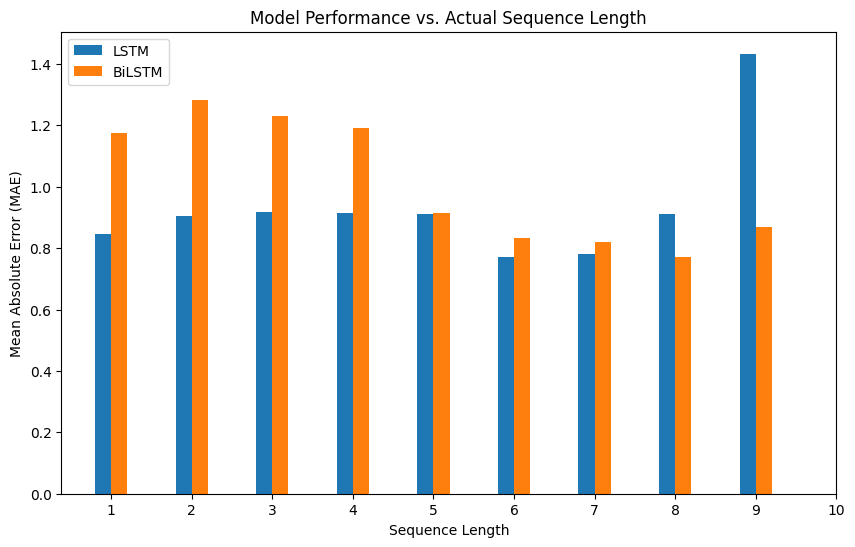

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Create the plot
plt.figure(figsize=(10, 6))
x = np.arange(1, max_sequence_length + 1)  # X-axis values (sequence lengths)

# Define the width of the bars
bar_width = 0.2

for i, (model_type, mae_values) in enumerate(mae_values_dict.items()):
    valid_mae_values = [mae for mae in mae_values if mae is not None]  # Filter out None values
    valid_x = x[:len(valid_mae_values)]
    plt.bar(valid_x + i * bar_width, valid_mae_values, width=bar_width, label=model_type)

plt.xlabel('Sequence Length')
plt.ylabel('Mean Absolute Error (MAE)')
plt.title('Model Performance vs. Actual Sequence Length')
plt.xticks(x + bar_width * (len(mae_values_dict.keys()) - 1) / 2, x)  # Adjust the x-axis ticks
plt.legend()
plt.show()


267/267 [==============================] - 1s 3ms/step
MAE After Permutition of AgeAtCalvingInDays : 3.7647352367103166
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of AverageBodyScore : 3.6851838556212404
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of AverageMotionScore : 3.5584703147151533
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of InbreedingCoefficient : 3.626741356709843
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of StillBirth : 3.4840616917771854
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of Abortion : 3.5817746815341267
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of MultiBirth : 3.478487302736554
267/267 [==============================] - 1s 3ms/step
MAE After Permutition of NaturalBreeding : 3.4586529679139693
267/267 [==============================] - 1s 3ms/step
MAE After Permu

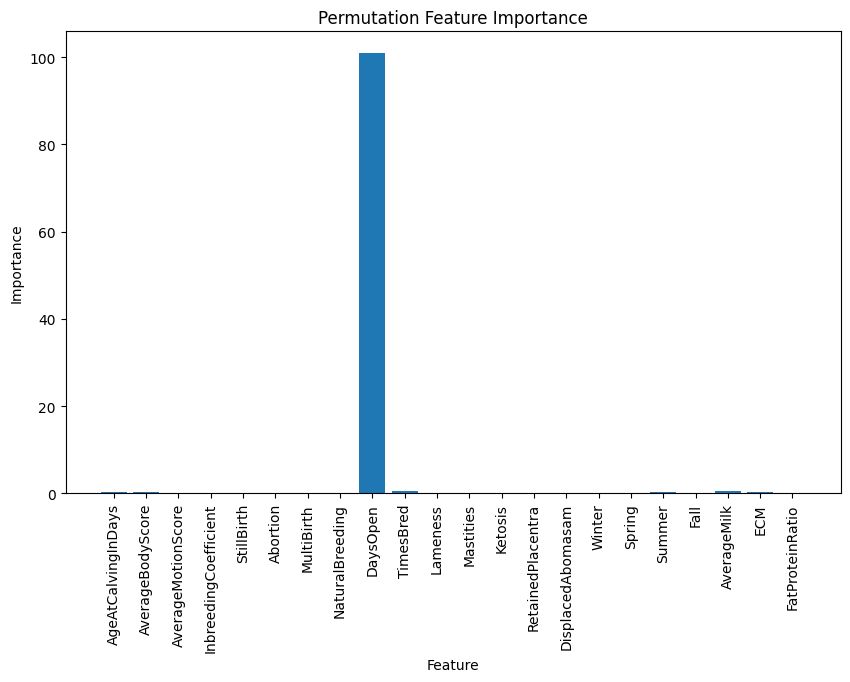

In [ ]:
from sklearn.metrics import mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt

# Assume X_test and y_test are your test data
# Assume model is your trained LSTM model

# Compute the baseline performance of the model
baseline_mae = mean_absolute_error(y_test, model.predict(X_test))

# Initialize an array to hold the feature importances
feature_importances = np.zeros(X_test.shape[2])

# Loop over the features
for i in range(X_test.shape[2]):
    # Make a copy of the test data
    X_test_permuted = X_test.copy()

    # Permute the values of the feature
    for j in range(X_test.shape[1]):
        np.random.shuffle(X_test_permuted[:, j, i])

    # Compute the performance of the model on the permuted data
    mae_permuted = mean_absolute_error(y_test, model.predict(X_test_permuted))

    print(f"MAE After Permutition of {feature_columns[i]} : {mae_permuted}")

    # The feature importance is the decrease in performance
    feature_importances[i] =  mae_permuted - baseline_mae

# Plot the feature importances
# Plot the feature importances
plt.figure(figsize=(10,6))
plt.bar(feature_columns, feature_importances)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Permutation Feature Importance')
plt.xticks(rotation='vertical')  # Rotate feature names for readability
plt.show()

In [ ]:
import pandas as pd

# Create a DataFrame with feature names and importances
df_importances = pd.DataFrame({
    'Feature': feature_columns,
    'Importance': feature_importances
})

# Sort the DataFrame by importance
df_importances = df_importances.sort_values(by='Importance', ascending=False)

# Display the DataFrame
df_importances

,Feature,Importance
8,DaysOpen,100.870926
9,TimesBred,0.519471
19,AverageMilk,0.440412
20,ECM,0.337329
0,AgeAtCalvingInDays,0.311519
1,AverageBodyScore,0.231968
17,Summer,0.196006
3,InbreedingCoefficient,0.173526
21,FatProteinRatio,0.162071
10,Lameness,0.138729


In [ ]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
import plotly.graph_objects as go

# Evaluate the model on the test data
score = model.evaluate(X_test, y_test, batch_size=32)
print('Test loss:', score)

# Use the model to make predictions
y_pred = model.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
medae = median_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print('Mean Absolute Error (MAE):', mae)
print('Mean Squared Error (MSE):', mse)
print('Median Absolute Error (MedAE):', medae)
print('R-squared (R2):', r2)



267/267 [==============================] - 1s 3ms/step - loss: 3.4532 - mean_absolute_error: 3.4532
Test loss: [3.4532172679901123, 3.4532172679901123]
267/267 [==============================] - 1s 3ms/step
Mean Absolute Error (MAE): 3.453215856555129
Mean Squared Error (MSE): 105.75803829464292
Median Absolute Error (MedAE): 1.62664794921875
R-squared (R2): 0.9910231075387549


In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Assuming y_test and y_pred are numpy arrays
x_values = np.arange(len(y_test))

# Round the prediction values to natural numbers
y_pred_rounded = np.round(y_pred.flatten())

# Create a scatter plot
plt.figure(figsize=(10, 6))

# Plot true values in blue with smaller dots (s parameter)
plt.scatter(x_values, y_test, label='True', color='blue', marker='o', s=5)

# Plot predicted values (rounded) in red with smaller dots (s parameter)
plt.scatter(x_values, y_pred_rounded, label='Predicted', color='red', marker='x', s=5)

# Draw lines connecting true and predicted values
for x, yt, yp in zip(x_values, y_test, y_pred_rounded):
    plt.plot([x, x], [yt, yp], color='green', linestyle='--', linewidth=1)

plt.title('True vs. Predicted Values')
plt.xlabel('Sample Index')
plt.ylabel('Days Open')
plt.legend()
plt.grid(True)

plt.show()


NameError: name 'y_pred' is not defined

In [ ]:

# Distribution of true values and predicted values
fig4 = go.Figure()

# Plot histogram of true values in blue
fig4.add_trace(go.Histogram(x=y_test, nbinsx=20, name='True', marker=dict(color='blue'), opacity=0.7))

# Plot histogram of predicted values in red
fig4.add_trace(go.Histogram(x=y_pred.flatten(), nbinsx=20, name='Predicted', marker=dict(color='red'), opacity=0.7))

fig4.update_layout(title='Distribution of True vs. Predicted Values',
                   xaxis_title='Days Open',
                   yaxis_title='Frequency',
                   barmode='overlay')

fig4.update_traces(opacity=0.75)


fig4.show()


In [ ]:
print(y_pred.squeeze().shape, y_test.squeeze().shape)

(8513,) (8513,)


In [ ]:


# Calculate percentage of predicted values greater than actual test values
greater_count = np.sum(y_pred.squeeze() > y_test.squeeze())
greater_percentage = greater_count / y_pred.squeeze().shape[0] * 100

# Calculate percentage of predicted values lower than actual test values
lower_count = np.sum(y_pred.squeeze() < y_test.squeeze())
lower_percentage = lower_count / y_pred.squeeze().shape[0] * 100

# Create a bar chart
fig = go.Figure(data=[go.Bar(x=['Greater', 'Lower'], y=[greater_percentage, lower_percentage])])
fig.update_layout(title='Percentage of Predicted Values Greater/Lower Than Actual Test Values')
fig.show()